In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Dynamic Segmentation Analysis

The industrial partner's problem was this: for a large and high-dimensional time-series dataset of characteristics about people, clustering has been performed at time 0 using Principle Component Analysis and each person has been assigned a cluster according to a least-distance-from-centroid rule. However, people drift over time as new data is collected about them. Assuming the clustering algorithm itself is expensive and we don't want to re-run it unless we *really* have to, is there a quick way to tell from the data when the clusters we've computed no longer suit the data? Can we make cluster-based predictions about individual people's futures, and figure out whether someone moving cluster is a temporary or permanent change?

This problem was pretty difficult. The best insight we came up with is that it's better to view a person's future trajectory of cluster membership not from a component timeseries but from a distance-from-centroid timeseries.

In [52]:
clusters = pd.read_csv("cluster_centroids.csv", index_col=0)

In [53]:
clusters

,PC1,PC2,PC3,PC4,PC5
1,-1.937133,0.688206,-0.081055,-0.235371,-0.100406
2,-2.105954,-0.892186,-0.435836,0.196749,0.005177
3,-1.551037,0.679669,-0.121671,-0.071197,0.664994
4,-1.169982,-0.329035,-0.037774,-0.324301,0.608058
5,-1.815465,-0.428648,-0.001424,-0.505800,-0.045492
6,-1.592880,0.436943,0.637748,0.272579,-0.259049
7,-2.120904,0.175774,-0.582111,0.518592,-0.081445
8,-1.583789,-0.716070,0.847662,0.065260,-0.027680
9,-0.970475,0.470901,0.742901,0.571586,0.669203


In [84]:
#Import and clean data
users = pd.read_csv("users.csv")
names = pd.read_csv("babynames-clean.csv", header=None)[0]
names_thinned = names.loc[0:4999].sort_values().reset_index(drop=True)
users['name'] = names_thinned.loc[np.arange(500000)%5000].reset_index(drop=True)
users['index'] = np.arange(0, 500000)
users

,user_id,X1,X2,X3,X4,X5,segment,timestep,name,index
0,0e4462619ea57227,-1.831466,-0.650351,0.197313,-0.493432,-0.011009,5,1,Aaden,0
1,4f0ba79151ecafd0,-2.197727,0.466141,-0.498114,0.319934,0.042355,7,1,Aarav,1
2,ae3ea828cef1b00b,-1.865080,-0.865215,0.988488,0.315046,-0.287521,8,1,Aaron,2
3,db28a706574506bc,-2.015101,0.740773,-0.056192,-0.356938,0.252333,1,1,Ab,3
4,7f9a952dbfb8fdc6,-2.028605,0.695306,-0.171248,-0.272988,0.012481,1,1,Abb,4
...,...,...,...,...,...,...,...,...,...,...
499995,5c1464cac33b9284,-2.253020,-0.724551,-0.531023,0.326407,0.138745,2,100,Zola,499995
499996,7863b759b01d8c05,-1.796563,-2.017232,-0.189200,0.462924,0.286381,2,100,Zollie,499996
499997,6a85487abdd85d4a,-1.680264,0.450163,0.722640,0.370193,0.136355,6,100,Zona,499997
499998,2cd85272f2a13bb2,-1.424783,0.345424,0.207549,-0.252486,-0.475398,6,100,Zora,499998


## What influence does each component have on the classified cluster?

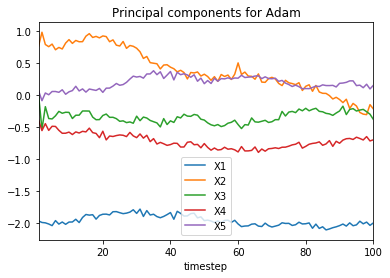

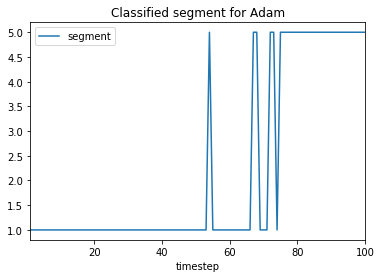

In [213]:
nm = 'Adam'
p1 = users.loc[users['name']==nm].plot(x='timestep', y=['X1', 'X2', 'X3', 'X4', 'X5'], title=f'Principal components for {nm}')
p2 = users.loc[users['name']==nm].plot(x='timestep', y='segment', title=f'Classified segment for {nm}')


## How close is someone to switching cluster?

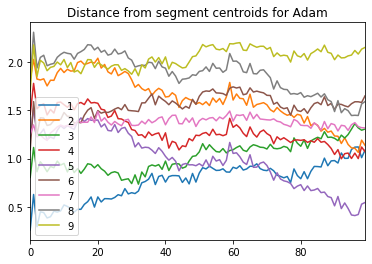

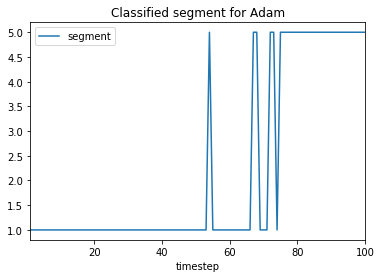

In [211]:
nm='Adam'

def distance_to_initial_centroid(row, clusters=clusters):
    # Calculates the distance between a point and all cluster centroids
    initial_segment=row['initial_segment']
    
    centroid_distances = np.zeros(9)
    
    for i in range(1, 10):
        sq_dist = (  (row['X1']-clusters.loc[i, 'PC1'])**2
                   + (row['X2']-clusters.loc[i, 'PC2'])**2
                   + (row['X3']-clusters.loc[i, 'PC3'])**2
                   + (row['X4']-clusters.loc[i, 'PC4'])**2
                   + (row['X5']-clusters.loc[i, 'PC5'])**2)
        centroid_distances[i-1] = np.sqrt(sq_dist)
    return(centroid_distances)


user = users.loc[users['name']==nm]
user_cd = user.apply(distance_to_initial_centroid, axis=1).reset_index(drop=True).apply(pd.Series).rename(lambda x: x+1, axis='columns')
p4 = user_cd.plot(title=f'Distance from segment centroids for {nm}')
p5 = users.loc[users['name']==nm].plot(x='timestep', y='segment', title=f'Classified segment for {nm}')


## Do people stay close to their original cluster?

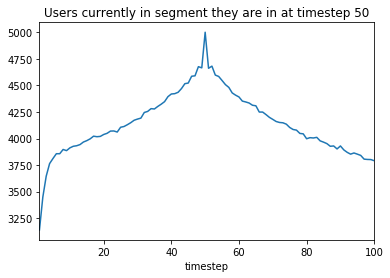

In [214]:
# How many people are switching cluster?

timestep = 50

x2 = (timestep-1) * 5000
initial_segments = users.loc[0+x2:4999+x2, 'segment']
initial_segments_repeated = np.tile(initial_segments.values, 100)
users['initial_segment'] = initial_segments_repeated
users['no_segment_change'] = users['segment']==users['initial_segment']
p3 = users.groupby('timestep')['no_segment_change'].sum().plot(title=f"Users currently in segment they are in at timestep {timestep}")